In [1]:
import subprocess
import sys

In [2]:
#noexport
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from fastai.basics import *


Bad key "text.kerning_factor" on line 4 in
/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
if not IN_NOTEBOOK:
    class IPython():
        @staticmethod
        def system(cmd): print(subprocess.run(cmd.split(" "),text=True,capture_output=True).stdout)
    def get_ipython(): return IPython()
def install(package): subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [5]:
#noexport
from __future__ import print_function
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, IntSlider


In [6]:
import os

import torch
from fastai.vision.all import *
from fastai.distributed import *
import fastai
DistributedTrainer.fup=True #added
import sklearn.metrics as skm
import pandas as pd
#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', 170)
#pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import openslide
from numpy import asarray
import cv2

pd.set_option('display.max_columns', None)

from TMA_tools import Spot, TMA, WSI

#added
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from torchvision import transforms
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import timm
from torchvision.models import *
from fastcore.script import *
import ast
import gc
from ast import literal_eval
import datatable as dt
import dcor

In [7]:
#noexport
import fastai
fastai.__file__,fastai.__version__,torch.__version__

('/home/auri/anaconda3/envs/fastaiAP/lib/python3.7/site-packages/fastai/__init__.py',
 '2.1.5',
 '1.7.0')

In [8]:

#%run TMA_tools.ipynb

In [9]:
@call_parse
def main(
    lr:             Param("Learning rate", float)=5e-4,
    bs:             Param("Batchs size",int)=64,
    test_slices:    Param("Number of partitions of each record during test",int)=100,
    test_bs:        Param("Batchs size in test",int)=100,
    epochs:         Param("Epochs", int)=10,
    fold:           Param("Fold", int)=0, #if -1 then it is an inmutable single fold (no k-Folds) 
    folds:          Param("Number of fold", int)=5,
    j:              Param("Num workers", int)=8,
    arch:           Param("Conv trunk architecture",str) = 'efficientnet_b3',
    fp16:           Param("fp16 method: to_fp16, to_non_native_fp16, none", str) = 'noop',
    mixover:        Param("Use mixover",action='store_true')=False,
    mixup:          Param("Use mixup",action='store_true')=False,
    coord:          Param("Use coordconv",action='store_true')=True,
    do:             Param("Spectral dropout", float)=0.5,
    jitter:         Param("Jitter, percentage of total length, e.g. 0.1", float)=0.,
    wn:             Param("White noise in dB, e.g. 4", float)=0.,

    fit:            Param("fit, fit_one_cycle, fit_flat_cos", str) = 'fit_one_cycle',
    fit_kwargs:     Param("Optional args for fit,eg pct_start=0.1", str, nargs='+') = {},

    opt:            Param("Optimizer", str) = 'Adam',
    opt_kwargs:     Param("Optional args for opt, eg. eps=1e-4", str, nargs='+') = {},
    
    sample_rate:    Param("",int)=48000,
    window_size:    Param("",int)=1024*2,
    hop_size:       Param("",int)=480,
    res_time:       Param("",int)=224*2,
    res_freq:       Param("",int)=256,
    
    ext:            Param("",str)="/home/auri/EPICOLON",
    
    #model:          Param("",str)="",
    task:           Param("",str,choices=['train','precache','ensemble'])="train",
    preds:          Param("Pred filenames",str,nargs='+')=[],
    pred_weights:   Param("Pred filenames",float,nargs='+')=None,
    
    pseudolabel_fns: Param("Pseudolabels files",str,nargs='+')=['pseudo.csv'],
    pseudolabels:    Param("Use pseudolabels",action='store_true')=False,

    local_rank:     Param("--local_rank",int)=None,
    nproc_per_node: Param("--nproc_per_node",int)=None,
    #added
    dataset:   Param('Dataset used for training', str) = 'epicolon', # 'epicolon' ,'TCGA'
    tissues:   Param('Type of tissues used for training', str, nargs='+')=['TUM','LYM','MUC'], #['TUM']['TUM','LYM','MUC']['TUM','STR', 'LYM', 'MUC']
    zoom_filter:  Param('Zoom level used for training', str)= None, # 0-4 in EPICOLON and 0-1 in TCGA. If None then all levels available
    pred_patient_img:  Param('Predict patient image with sliding tiles', action = 'store_true' ) = False,
    verbose:     Param("--verbose",bool)=False,
    test_saved_model:  Param('Name of the saved model for testing', str) = None, #if None then it will train a new model otherwise will test the saved model 
    control_bias:  Param('Control bias when training', int, nargs='+')=[1,2,3], #if empty then vanilla training, 1=control hospital bias, 2=control patient bias, 3=control TMA bias
    distillation_start:  Param('% of iterations in first epoch prior to bias distillation', int) = 50, #if 0 then distillation starts at the beginning  
    distillation_period:  Param('Number of iterations each bias distillation occurs', int) = 1, #if 1 then distillation is done on each iteration 
    distillation_weight: Param('Weight in loss of distillation rejection term', float) = 100.,
): 
    if opt_kwargs: opt_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in opt_kwargs}
    if fit_kwargs: fit_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in fit_kwargs}
    print(locals())
    globals().update({ 'a' : AttrDict(locals())})

In [10]:
#noexport
main(fp16='to_fp16', verbose = True, dataset = 'TCGA',
     test_saved_model = "0_MSI_classifier_TissueBackbone_Corr_Loss_epicolon_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[1, 2, 3]_DistillationWeight=0.0_maxepochs=10_AUC=0.8186093986809806",
     control_bias = [1,2,3],  )

{'lr': 0.0005, 'bs': 64, 'test_slices': 100, 'test_bs': 100, 'epochs': 10, 'fold': 0, 'folds': 5, 'j': 8, 'arch': 'efficientnet_b3', 'fp16': 'to_fp16', 'mixover': False, 'mixup': False, 'coord': True, 'do': 0.5, 'jitter': 0.0, 'wn': 0.0, 'fit': 'fit_one_cycle', 'fit_kwargs': {}, 'opt': 'Adam', 'opt_kwargs': {}, 'sample_rate': 48000, 'window_size': 2048, 'hop_size': 480, 'res_time': 448, 'res_freq': 256, 'ext': '/home/auri/EPICOLON', 'task': 'train', 'preds': [], 'pred_weights': None, 'pseudolabel_fns': ['pseudo.csv'], 'pseudolabels': False, 'local_rank': None, 'nproc_per_node': None, 'dataset': 'TCGA', 'tissues': ['TUM', 'LYM', 'MUC'], 'zoom_filter': None, 'pred_patient_img': False, 'verbose': True, 'test_saved_model': "0_MSI_classifier_TissueBackbone_Corr_Loss_epicolon_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[1, 2, 3]_DistillationWeight=0.0_maxepochs=10_AUC=0.8186093986809806", 'control_bias': [1, 2, 3], 'distillation_start': 50, 'distillation_period': 1, 'distillation_weight'

In [11]:
n_gpus = torch.cuda.device_count() if a.local_rank is None else 1
if a.local_rank is not None:
    torch.cuda.set_device(a.local_rank)
    torch.distributed.init_process_group(backend='nccl', init_method='env://')
    if a.j: a.j = min(1,a.j//num_distrib())
    print("DISTRIBUTED")

In [12]:

_p_csv = Path('dataset_level_all_March21_no_overlap_labeled_tissue.csv') #HGUA samples
p_csv = Path('dataset_level_all_no_overlap_labeled_tissue.csv') #Epicolon I and II
_p_csv_1 = Path('dataset_TCGA_MSI-H_level_0_no_overlap_labeled_tissue.csv') #TCGA MSI
_p_csv_0 = Path('dataset_TCGA_MSS_level_0_no_overlap_labeled_tissue.csv') #TCGA MSS

if a.dataset == 'TCGA':
    d = dt.fread(_p_csv_0).to_pandas()
    print(d.shape)
    _d = dt.fread(_p_csv_1).to_pandas()
    d = pd.concat([d,_d])
    d.shape #n tiles extracted from TCGA 

if a.dataset == 'epicolon':
    d = dt.fread(p_csv).to_pandas()
    print(d.shape)
    _d = dt.fread(_p_csv).to_pandas()
    d = pd.concat([d,_d])
    d.shape #n tiles extracted from EPICOLON I and II + HGUA  
    #correct labels in two patients with mixed labels in source data (verified with AP)
    d.loc[d.patient_ID == '13013', 'label'] = 2 #MSS
    d.loc[d.patient_ID == '06B0014684A','label'] = 1 #MSI



(1559775, 8)


In [13]:
#d = d.sample(frac = 0.1,random_state=123)

In [14]:

print(f'N patients IDs (if EPICOLON total is not disambiguated): {d.patient_ID.nunique()}, ( MSI {d.loc[d.label == 1].patient_ID.nunique()})')

N patients IDs (if EPICOLON total is not disambiguated): 232, ( MSI 59)


In [15]:
def eval_fields(df):
    df.tile = df.tile.apply(lambda x: eval(str(x)))
    
    if a.dataset == 'epicolon':
        df.tile_rot_augmentation = df.tile_rot_augmentation.apply(lambda x: eval(str(x)))
    return df
df_split = np.array_split(d, 32)

res = parallel(partial(eval_fields), df_split)
d = pd.concat([*res])



In [16]:
#noexport
d['zoom'] = d.tile.apply(lambda o: o[3])
d.zoom.value_counts()

0    2064414
Name: zoom, dtype: int64

In [17]:

d.patient_ID = d.patient_ID.astype(str)



In [18]:
#disambiguate IDs
if a.dataset == 'epicolon':
    #print(d[d.patient_ID.str.contains('.0', regex = False)].patient_ID.nunique())
    d['patient_ID'] = d.patient_ID.str.replace('.0','', regex=False)
    #correct labels in two patients with mixed labels in source data (verified with AP)
    d.loc[d.patient_ID == '13013', 'label'] = 2 #MSS 
    d.loc[d.patient_ID == '06B0014684A','label'] = 1 #MSI
    print('after disambiguation')
    print(d.patient_ID.nunique(), d.loc[d.label == 1].patient_ID.nunique())
#df with a tile covering the entire area of each spot
ds_spot_4 = d.loc[d.zoom == 4] 


In [19]:
cls = ['ADI', 'BAC', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']
if a.dataset == 'TCGA':
    d['clas_idx_notdecoded'] = d.clas_idx
    d.clas_idx = d.clas_idx.apply(lambda o: cls[o])

In [20]:
d.clas_idx.unique()

array(['STR', 'DEB', 'TUM', 'ADI', 'NOR', 'LYM', 'BAC', 'MUS', 'MUC'],
      dtype=object)

In [21]:
#filter tissues to train model
d = d.loc[d.clas_idx.isin(a.tissues)] 
d.shape

(1113572, 10)

In [22]:
if a.zoom_filter: 
    d = d.loc[d.zoom == zoom_filter]

d.shape

(1113572, 10)

In [23]:
d.reset_index(inplace = True)

In [24]:
d.drop(columns = ['index', 'C0'], inplace = True)

In [25]:
#noexport
d.label.describe()

count    1.113572e+06
mean     1.762146e+00
std      4.257697e-01
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: label, dtype: float64

d['zoom'] = d.tile.apply(lambda x: x[3])
d.zoom

In [26]:
if a.dataset == 'epicolon':
    patient_label = d.groupby(['patient_ID','label']).groups.keys()
    patient_label = pd.DataFrame({'patient_ID' : np.array([list(i) for i in list(patient_label)])[:,0], 'label' : np.array([list(i) for i in list(patient_label)])[:,1]})
    patient_label['HGUA'] = patient_label.patient_ID.apply(lambda x: 1 if ('B' in x or '-' in x or x.startswith('12')) else 0)
    print(patient_label.groupby(['label', 'HGUA']).describe())

In [27]:
if a.dataset == 'epicolon':
    patient_label['bias_label'] = pd.to_numeric(patient_label.label, downcast='integer')*10 + patient_label.HGUA.apply(int)
    patient_label = patient_label[patient_label.bias_label < 31]
    patient_label['bias_label'].value_counts()

In [28]:
weights = None
if a.dataset == 'epicolon':
    classes = patient_label['bias_label'].unique()
    weights = compute_class_weight('balanced', classes=classes, y=patient_label['bias_label'])
    print(classes, weights)
    weights_df = pd.DataFrame({'bias_label': classes, 'weights': weights})
    f = d.merge(patient_label[['patient_ID','bias_label']], on = 'patient_ID')
    f = f.merge(weights_df, on = 'bias_label')

else:
    classes = d.label.unique()
    weights = compute_class_weight('balanced', classes=classes, y=d.label)
    print(classes, weights)
    weights_df = pd.DataFrame({'label': classes, 'weights': weights})
    f = d.merge(weights_df, on = 'label') #TODO this is for testing in TCGA, not for distilled bias training in TCGA 


[2 1] [0.65604262 2.10212634]


### Partitions

In [29]:
#fixed partitions (no k-folds) and splitter
if a.fold == -1:
    if a.dataset == 'epicolon'  : 
        patient_label['valid'] = 0
        patient_label.loc[patient_label.index.isin(patient_label.sample(frac=0.2, random_state=1).index), 'valid'] = 1
        patient_label.groupby('bias_label').describe()
        #check inmmutable patient valid partition 
        patient_df = pd.read_csv('valid_partition_TUM_only.csv')
        valid_set_csv = set(patient_df[patient_df.valid == 1].patient_ID)
        valid_set = set(patient_label[patient_label.valid == 1].patient_ID)
        assert len(valid_set - valid_set_csv.intersection(valid_set)) == 0 #only match valid in csv if TUM is selected as single tissue
        f = d.merge(patient_label[['patient_ID','valid']], on = 'patient_ID')
        
    if a.dataset == 'TCGA' :
        f['valid'] = 0
        patient_keys_MSS, patient_keys_MSI = f.loc[f.label == 2].patient_ID.unique(), f.loc[f.label == 1].patient_ID.unique()
        print(f'MSS patients = {len(patient_keys_MSS)} ({len(patient_keys_MSS)*100/f.patient_ID.nunique()}%)')
        print(f'MSI patients = {len(patient_keys_MSI)} ({len(patient_keys_MSI)*100/f.patient_ID.nunique()}%)')
        f.loc[f.patient_ID.isin(pd.Series(patient_keys_MSS).sample(frac = 0.2, random_state = 42).values), 'valid'] = 1
        f.loc[f.patient_ID.isin(pd.Series(patient_keys_MSI).sample(frac = 0.2, random_state = 42).values), 'valid'] = 1
        
        
    #Assert training and validation partition avoids patient overlap
    assert len(set(f[f.valid == 0].patient_ID.unique()) & set(f[f.valid == 1].patient_ID.unique()) ) == 0
    f.groupby(['label', 'valid']).describe()
    d_sub = f
    print(f'{d_sub.patient_ID.nunique()} patients ( {d_sub.loc[(d_sub.valid == 1)].patient_ID.nunique()} validation )')  
    print(f'MSI {d_sub.loc[d_sub.label == 1].patient_ID.nunique()} patients ( {d_sub.loc[(d_sub.label == 1) & (d_sub.valid == 1)].patient_ID.nunique()} validation )')  #as level 4 with scarce tissue were excluded, there are less patients in level 4 than in other levels  
    
    
    d_sub = d_sub.sample(frac=1).reset_index(drop=True)
    splitter = ColSplitter('valid')
    error_label = set(d_sub.iloc[splitter(d_sub)[0]].patient_ID.unique()).intersection(set(d_sub.iloc[splitter(d_sub)[1]].patient_ID.unique()))
    print(f'mixed labels:  {error_label}')
    assert(set(d_sub.iloc[splitter(d_sub)[0]].patient_ID.unique()).intersection(set(d_sub.iloc[splitter(d_sub)[1]].patient_ID.unique())) == set())
    assert(np.round(d_sub.iloc[splitter(d_sub)[0]].label.mean(), decimals=1
           ) == np.round(d_sub.iloc[splitter(d_sub)[0]].label.mean(), decimals = 1))
    example = d_sub.iloc[splitter(d_sub)[1]].iloc[72]
        

In [30]:
#generate k-folds 
if a.fold >= 0:
    ids = L(sorted(set(f.patient_ID.unique())))
    from sklearn.model_selection import KFold
    for i,(train_idx,valid_idx) in enumerate(KFold(n_splits=a.folds,random_state=123,shuffle=True).split(ids)):
        if i == a.fold: break
    train_records,valid_records = ids[train_idx],ids[valid_idx]
    print(f'Train patients {len(train_records)}, Valid patients {len(valid_records)}')
    f['valid'] = 0
    f.loc[f.patient_ID.isin(valid_records), 'valid'] = 1
    
    print(f'Tiles in train and validation: {f.valid.value_counts().values}')
    print(f'% of MSI')
    print(((2 - f[['valid','label']].groupby(['valid']).mean()) * 100).round())
    d_sub = f

Train patients 185, Valid patients 47
Tiles in train and validation: [921334 192238]
% of MSI
       label
valid       
0       26.0
1       13.0


In [31]:
#f.tif_fn.value_counts()

In [32]:
def get_x(r):
    img = None
    if a.dataset == 'epicolon':
        img = Spot.get_tile(Spot, *(r.tile), path=r.path, tif_name = r.tif_fn)
    if a.dataset == 'TCGA':
        img = WSI.get_tile(*(r.tile), path=r.path, svs_fn = r.svs_fn)
    
    return img
    

def label_func(r): 
    s = None
    try:
        s = 'MSI' if r.label == 1 else 'MSS'
    except :
        print(r)
   
    return s 

def label_bias_func(r): 
    s = None
    try:
        if a.dataset == 'epicolon':
            s = 'HGUA' if 'B' in r.spot_ID else 'Other'
        if a.dataset == 'TCGA': 
            s = 'TCGA' #TODO: fix in table, label_bias not yet implemented for TCGA 
    except :
        print(f)
    
    return s 

def label_bias1_func(r): 
    s = None
    try:
        s = r.patient_ID
    except:
        print(r)
    
    return s 

def label_bias2_func(r): 
    s = None
    try:
        s = r.tif_fn
    except:
        print(r)
    
    return s 

def label_double_func(r):
    
    return ([label_func(r), label_bias_func(r)])


def label_triple_func(r):
    
    return ([label_func(r), label_bias_func(r), label_bias1_func(r)])

def label_quatr_func(r):
    
    return ([label_func(r), label_bias_func(r), label_bias1_func(r), label_bias2_func(r)])


In [33]:

pd.options.mode.chained_assignment = None  # default='warn'





In [34]:
#noexport
test_example = True

['MSS', 'TCGA']
['MSS', 'TCGA', 'TCGA-AA-A02H']
tile                                                   [12223, 6917, (300, 300), 0]
path                                                                       TCGA/SVS
svs_fn                 TCGA-AA-A02H-01A-01-BS1.4a22c6cb-1222-4b9e-b884-85dd469be4b1
patient_ID                                                             TCGA-AA-A02H
label                                                                             2
clas_idx                                                                        TUM
probs                             [0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.02, 0.01, 0.96]
zoom                                                                              0
clas_idx_notdecoded                                                               8
weights                                                                    0.656043
valid                                                                             0
Name: 10, dtype: object
['MS

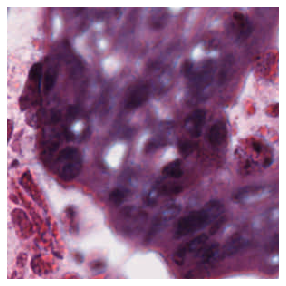

In [35]:
#noexport
if test_example:
    #example = d_sub.iloc[splitter(d_sub)[1]].iloc[4582]
    example = d_sub.iloc[10]
    print(label_double_func(example))
    print(label_triple_func(example))
    print(label_quatr_func(example))
    print(example)
    pati = get_x(example)
    show_image(pati)
        

In [36]:

tissue_stats =  ([0.6365042 , 0.4866035 , 0.66030514],[0.2311546 , 0.27366328, 0.19013868]) #EPICOLON TUM+STR+LYM selected
#tissue_stats =  ([0.7700158 , 0.6154052 , 0.74566764],[0.19486967, 0.26420233, 0.19368471]) #TSR-CRC + NCT-CRC-HE
#tissue_stats = ([0.6698, 0.5181, 0.6594], [0.2080, 0.2573, 0.1874]) #TCGA svs  
#tissue_stats = ([0.6865583 , 0.5289199 , 0.66556716], [0.20485608, 0.2561432 , 0.18819469]) #TCGA svs TUM+STR+LYM selected
tissue_stats

([0.6365042, 0.4866035, 0.66030514], [0.2311546, 0.27366328, 0.19013868])

In [37]:
_d_sub = d_sub#.sample(frac=.01)


In [38]:
#def img2tensor(im: Image.Image): return TensorImage(array(im)[None])
patient_classes = L(sorted(set(_d_sub.patient_ID.unique())))
if a.dataset == 'epicolon':
    TMA_classes = L(sorted(set(_d_sub.tif_fn.unique())))
else:
    TMA_classes = ['Dummy','NoDummy']
def img2tensor(img: np.ndarray): 
    t = torch.Tensor(np.array(img))
    t = t.permute(2,0,1).float()/255.0
    return TensorImage(t)
if a.dataset == 'epicolon':
    tfms = [[get_x, img2tensor],
       [label_func, Categorize(vocab = ['MSS', 'MSI'], sort = False)],
       [label_bias_func, Categorize(vocab = ['Other', 'HGUA', 'TCGA'], sort = False)],
       [label_bias1_func, Categorize(vocab = patient_classes, sort = False)],
       [label_bias2_func, Categorize(vocab = TMA_classes, sort = False)]]
else:
    tfms = [[get_x, img2tensor],
       [label_func, Categorize(vocab = ['MSS', 'MSI'], sort = False)],
       [label_bias_func, Categorize(vocab = ['Other', 'HGUA', 'TCGA'], sort = False)],
       [label_bias1_func, Categorize(vocab = patient_classes, sort = False)],
       ]
train_ds = Datasets(_d_sub[_d_sub.valid == 0],tfms,n_inp=1)
valid_ds = Datasets(_d_sub[_d_sub.valid == 1],tfms,n_inp=1)

In [39]:
#noexport
example = 5
xd,yd, yd1, yd2,  = decode_at(train_ds,example)
xd.shape,yd, yd1, yd2

(torch.Size([3, 300, 300]), 'MSS', 'TCGA', 'TCGA-AA-A02H')

In [40]:
#noexport
x,y,y1, y2, = train_ds[example]
x,y,y1, y2,

(TensorImage([[[0.8627, 0.8706, 0.8745,  ..., 0.9255, 0.9255, 0.9255],
          [0.8118, 0.8235, 0.8275,  ..., 0.9294, 0.9294, 0.9294],
          [0.7765, 0.7843, 0.7882,  ..., 0.9373, 0.9373, 0.9373],
          ...,
          [0.4745, 0.4824, 0.4824,  ..., 0.2863, 0.2980, 0.3137],
          [0.4588, 0.4667, 0.4627,  ..., 0.2706, 0.2824, 0.3020],
          [0.4431, 0.4588, 0.4549,  ..., 0.2627, 0.2745, 0.2980]],
 
         [[0.8471, 0.8392, 0.8314,  ..., 0.9137, 0.9137, 0.9137],
          [0.8000, 0.7961, 0.7882,  ..., 0.9137, 0.9137, 0.9137],
          [0.7529, 0.7451, 0.7451,  ..., 0.9137, 0.9137, 0.9137],
          ...,
          [0.2667, 0.2784, 0.2784,  ..., 0.1412, 0.1412, 0.1451],
          [0.2588, 0.2588, 0.2588,  ..., 0.1373, 0.1373, 0.1412],
          [0.2510, 0.2392, 0.2392,  ..., 0.1294, 0.1333, 0.1373]],
 
         [[0.8980, 0.8980, 0.8980,  ..., 0.9137, 0.9137, 0.9137],
          [0.8588, 0.8667, 0.8667,  ..., 0.9137, 0.9137, 0.9137],
          [0.8196, 0.8314, 0.8353, 

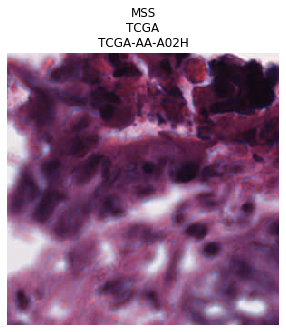

In [41]:
#noexport
show_at(train_ds, example, figsize=(5,5))

In [42]:
#noexport
timg = x
def _batch_ex(bs): return TensorImage(timg[None].expand(bs, *timg.shape).clone())

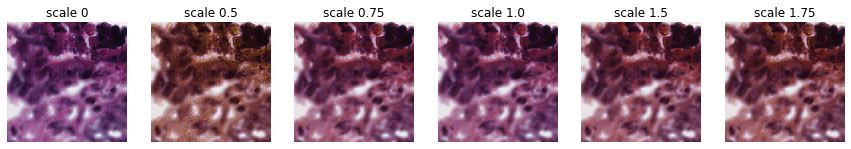

In [43]:
#noexport
scales = [0,0.5, 0.75, 1., 1.5, 1.75]
y = _batch_ex(len(scales)).saturation(max_lighting= 0.4, p=1., )
y = _batch_ex(len(scales)).hue(max_hue= 0.15, p=1., )
fig,axs = plt.subplots(1,len(scales), figsize=(15,3))
for i,ax in enumerate(axs.flatten()): show_image(y[i], ctx=ax, title=f'scale {scales[i]}')

In [44]:
bs = 8* 64 * torch.cuda.device_count()
print(f'batch size= {bs}')
#aug = aug_transforms(mult=2, flip_vert=True, max_rotate=90., min_zoom=0.5, max_zoom=5, size = 224)
aug = aug_transforms(mult=1, flip_vert=True, max_rotate=90., min_zoom=1, max_zoom=1, size = 224,
                 max_lighting=0,p_lighting=0, 
                    xtra_tfms=[Saturation(max_lighting=0.4,p=1), Hue(max_hue = 0.2, p= 1)])
wgts = _d_sub[_d_sub.valid == 0].weights.values

batch size= 512


In [45]:
calculate_stats = False
if calculate_stats:
    train_dl = WeightedDL(train_ds,shuffle=True,bs=5000, device=default_device(),
                     wgts=wgts,)
    valid_dl = WeightedDL(valid_ds,wgts=None,bs=2500)
    dls = DataLoaders(train_dl, valid_dl, device=default_device(), )
    print (dls[0].after_batch)
    bx=dls.one_batch()[0]
    print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
    tissue_stats = (np.array(bx.mean(dim=[0,2,3]).cpu()),np.array(bx.std(dim=[0,2,3]).cpu()))
    print(tissue_stats)

    

In [46]:


train_dl = WeightedDL(train_ds,shuffle=True,bs=bs, num_workers=a.j,
                      after_batch=[Normalize.from_stats(*tissue_stats), *aug,],
                     device=default_device(),
                     wgts=wgts,)
valid_dl = TfmdDL(valid_ds,bs=bs,num_workers=a.j,after_batch=[Normalize.from_stats(*tissue_stats)])
test_dl  = TfmdDL(train_ds,bs=bs,num_workers=a.j,after_batch=[Normalize.from_stats(*tissue_stats)])

In [47]:
dls = DataLoaders(train_dl, valid_dl, test_dl, device=default_device(), )

In [48]:
#noexport
dls.train.dataset

(#921334) [(TensorImage([[[0.2392, 0.2824, 0.3216,  ..., 0.3412, 0.3333, 0.3216],
         [0.2431, 0.2941, 0.3490,  ..., 0.3412, 0.3333, 0.3373],
         [0.2471, 0.3059, 0.3686,  ..., 0.3412, 0.3373, 0.3451],
         ...,
         [0.2196, 0.2314, 0.2549,  ..., 0.4667, 0.4627, 0.4706],
         [0.2078, 0.2235, 0.2431,  ..., 0.4706, 0.4706, 0.4745],
         [0.2118, 0.2196, 0.2353,  ..., 0.4980, 0.4902, 0.4863]],

        [[0.0824, 0.1059, 0.1569,  ..., 0.1529, 0.1451, 0.1333],
         [0.0941, 0.1216, 0.1804,  ..., 0.1529, 0.1451, 0.1333],
         [0.1020, 0.1333, 0.1961,  ..., 0.1529, 0.1451, 0.1333],
         ...,
         [0.0627, 0.0667, 0.0706,  ..., 0.1922, 0.1922, 0.2000],
         [0.0627, 0.0667, 0.0706,  ..., 0.1961, 0.1961, 0.2039],
         [0.0667, 0.0667, 0.0667,  ..., 0.2196, 0.2196, 0.2235]],

        [[0.2431, 0.2706, 0.3255,  ..., 0.2941, 0.2863, 0.2824],
         [0.2510, 0.2784, 0.3294,  ..., 0.2980, 0.2902, 0.2824],
         [0.2549, 0.2824, 0.3294,  ..., 0

In [49]:
#noexport
dls.train.one_batch()

(TensorImage([[[[-1.2267, -1.3551, -1.4966,  ...,  0.4955,  0.1425, -0.0901],
           [-1.2490, -1.3994, -1.5478,  ...,  0.2455,  0.0077,  0.0932],
           [-1.2607, -1.4342, -1.5900,  ...,  0.1063, -0.1249, -0.0477],
           ...,
           [-1.1589, -1.3113, -1.2081,  ..., -0.9485, -1.1171, -1.3387],
           [-1.1356, -1.3189, -1.2399,  ..., -1.0859, -1.2380, -1.4323],
           [-1.0571, -1.1545, -1.0485,  ..., -1.2080, -1.3368, -1.4982]],
 
          [[-1.3052, -1.3339, -1.3640,  ...,  0.3143, -0.0832, -0.3021],
           [-1.3106, -1.3713, -1.4073,  ...,  0.1153, -0.1850, -0.1383],
           [-1.2909, -1.4006, -1.4430,  ...,  0.0243, -0.2706, -0.2377],
           ...,
           [-0.8467, -1.0876, -1.1391,  ..., -0.9900, -1.0533, -1.1418],
           [-0.7877, -1.0417, -1.1277,  ..., -1.0864, -1.1290, -1.1816],
           [-0.7034, -0.8790, -0.9484,  ..., -1.1805, -1.2004, -1.2192]],
 
          [[-1.6990, -1.7609, -1.7898,  ...,  0.3058,  0.0917, -0.2759],
        

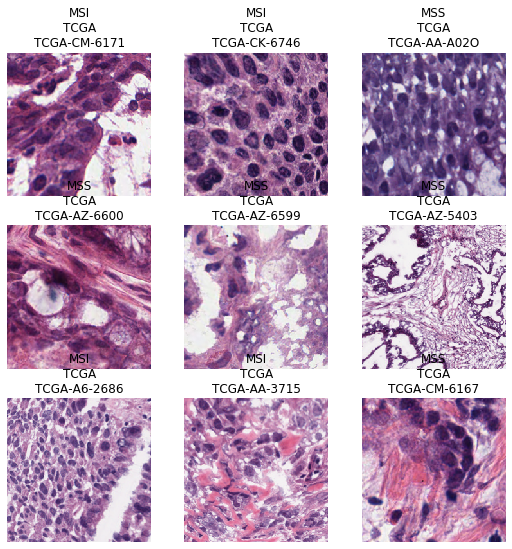

In [50]:
#noexport
dls.show_batch()

In [51]:
#noexport
dls.vocab

(#3) [['MSS', 'MSI'],['Other', 'HGUA', 'TCGA'],['TCGA-A6-2686', 'TCGA-A6-4105', 'TCGA-A6-4107', 'TCGA-A6-5657', 'TCGA-A6-5660', 'TCGA-A6-5661', 'TCGA-A6-5662', 'TCGA-A6-5664', 'TCGA-A6-5665', 'TCGA-A6-5667', 'TCGA-A6-6137', 'TCGA-A6-6138', 'TCGA-A6-6142', 'TCGA-A6-6648', 'TCGA-A6-6649', 'TCGA-A6-6651', 'TCGA-A6-6652', 'TCGA-A6-6653', 'TCGA-A6-6654', 'TCGA-A6-6782', 'TCGA-AA-3489', 'TCGA-AA-3492', 'TCGA-AA-3506', 'TCGA-AA-3510', 'TCGA-AA-3511', 'TCGA-AA-3655', 'TCGA-AA-3660', 'TCGA-AA-3663', 'TCGA-AA-3664', 'TCGA-AA-3666', 'TCGA-AA-3673', 'TCGA-AA-3678', 'TCGA-AA-3679', 'TCGA-AA-3681', 'TCGA-AA-3684', 'TCGA-AA-3685', 'TCGA-AA-3693', 'TCGA-AA-3696', 'TCGA-AA-3712', 'TCGA-AA-3713', 'TCGA-AA-3715', 'TCGA-AA-3811', 'TCGA-AA-3812', 'TCGA-AA-3814', 'TCGA-AA-3818', 'TCGA-AA-3821', 'TCGA-AA-3831', 'TCGA-AA-3833', 'TCGA-AA-3837', 'TCGA-AA-3842', 'TCGA-AA-3844', 'TCGA-AA-3845', 'TCGA-AA-3846', 'TCGA-AA-3848', 'TCGA-AA-3850', 'TCGA-AA-3851', 'TCGA-AA-3856', 'TCGA-AA-3858', 'TCGA-AA-3864', 'TCGA-AA

In [52]:
#noexport
print (dls[0].tfms)
print (dls[0].after_batch)
bx=dls.one_batch()[0]
print(bx.min(),bx.max(),bx.mean(dim=[0,2,3]),bx.std(dim=[0,2,3]))
aug

[Pipeline: get_x -> img2tensor, Pipeline: label_func -> Categorize -- {'vocab': ['MSS', 'MSI'], 'sort': False, 'add_na': False}, Pipeline: label_bias_func -> Categorize -- {'vocab': ['Other', 'HGUA', 'TCGA'], 'sort': False, 'add_na': False}, Pipeline: label_bias1_func -> Categorize -- {'vocab': ['TCGA-A6-2686', 'TCGA-A6-4105', 'TCGA-A6-4107', 'TCGA-A6-5657', 'TCGA-A6-5660', 'TCGA-A6-5661', 'TCGA-A6-5662', 'TCGA-A6-5664', 'TCGA-A6-5665', 'TCGA-A6-5667', 'TCGA-A6-6137', 'TCGA-A6-6138', 'TCGA-A6-6142', 'TCGA-A6-6648', 'TCGA-A6-6649', 'TCGA-A6-6651', 'TCGA-A6-6652', 'TCGA-A6-6653', 'TCGA-A6-6654', 'TCGA-A6-6782', 'TCGA-AA-3489', 'TCGA-AA-3492', 'TCGA-AA-3506', 'TCGA-AA-3510', 'TCGA-AA-3511', 'TCGA-AA-3655', 'TCGA-AA-3660', 'TCGA-AA-3663', 'TCGA-AA-3664', 'TCGA-AA-3666', 'TCGA-AA-3673', 'TCGA-AA-3678', 'TCGA-AA-3679', 'TCGA-AA-3681', 'TCGA-AA-3684', 'TCGA-AA-3685', 'TCGA-AA-3693', 'TCGA-AA-3696', 'TCGA-AA-3712', 'TCGA-AA-3713', 'TCGA-AA-3715', 'TCGA-AA-3811', 'TCGA-AA-3812', 'TCGA-AA-3814',

[Dihedral -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Saturation -- {'max_lighting': 0.4, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 Hue -- {'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 decodes: ]

# Model

In [53]:
#noexport
print(Path('models').ls())

[Path('models/segment_tissue_0.4554598927497864_f_acc_0.8807398080825806.pth'), Path('models/segment_tissue_0.3260129690170288_f_acc_0.900049090385437.pth'), Path('models/segment_tissue_presizing0.4628714621067047_f_acc_0.8756903409957886.pth'), Path('models/segment_tissue_presizing0.34281474351882935_f_acc_0.9168598055839539.pth'), Path('models/segment_tissue_9_class_2.2231385707855225_f_acc_nan.pth'), Path('models/segment_tissue_9_class.pth'), Path('models/pretrained_tissue_aug_0.999517653648182.pth'), Path('models/pretrained_tissue_aug_BAC_epicolon0.9993681800971788.pth'), Path('models/MSI_classifier_epicolon_0.8591032422872864.pth'), Path('models/MSI_classifier_epicolon_level_3_0.8562268910196152.pth'), Path('models/MSI_classifier_epicolon_level_2_0.8516107310959105.pth'), Path('models/MSI_classifier_epicolon_level_1_0.8722223505233963.pth'), Path('models/MSI_classifier_epicolon_level_0_0.8644301847354364.pth'), Path('models/MSI_classifier_epicolon_level_0_0.8745365282255746.pth'),

In [54]:
b = dls[0].one_batch()

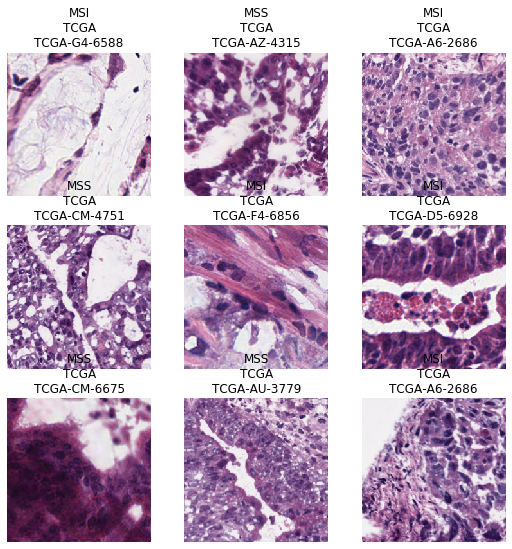

In [55]:
#noexport
dls.show_batch(b)

In [56]:
learn_pretrained = cnn_learner(dls, resnet34, metrics=[error_rate,RocAuc()],normalize=False, n_out=9,
                                  path=Path("."), pretrained=False, loss_func=CrossEntropyLossFlat())


tissue_model = 'pretrained_tissue_aug_BAC_epicolon0.9993681800971788'

learn_pretrained.load(tissue_model)
m_tissue_classifier =  learn_pretrained.model


    


In [57]:
#noexport
if test_example: #visually check tissue type classification in loaded dataset (TODO: check odd behaviour as all the samples were previously selected as TUM)
    #x = torch.randn(2,3,300,300)
    bx = b[0]
    _preds = m_tissue_classifier(bx.cpu())
    #print(preds)
    preds = torch.argmax(nn.Softmax(dim=-1)(_preds), dim = -1)
    #print(preds)
    classes = [cls[i] for i in preds]
    print(classes[:9])
    print(preds)

['ADI', 'LYM', 'LYM', 'TUM', 'MUS', 'DEB', 'BAC', 'TUM', 'ADI']
TensorImage([0, 3, 3, 8, 5, 2, 1, 8, 0, 6, 3, 5, 2, 5, 1, 3, 1, 2, 2, 0, 2, 7, 3, 4,
        1, 8, 4, 8, 3, 3, 7, 7, 4, 5, 6, 1, 2, 2, 5, 2, 0, 6, 0, 7, 4, 0, 4, 8,
        6, 7, 8, 6, 8, 5, 7, 0, 3, 6, 2, 3, 5, 8, 5, 4, 1, 6, 3, 3, 5, 3, 8, 2,
        0, 2, 8, 3, 5, 8, 8, 8, 5, 8, 8, 5, 2, 3, 0, 2, 3, 4, 2, 3, 5, 6, 2, 7,
        2, 1, 2, 5, 1, 4, 8, 1, 1, 8, 2, 2, 8, 2, 0, 2, 2, 1, 1, 6, 8, 0, 7, 8,
        6, 6, 0, 6, 2, 2, 4, 4, 8, 8, 8, 2, 5, 0, 2, 5, 7, 5, 5, 5, 2, 3, 2, 6,
        0, 4, 8, 3, 5, 8, 3, 3, 2, 3, 8, 2, 8, 6, 4, 1, 8, 7, 7, 3, 3, 5, 6, 2,
        7, 8, 8, 8, 2, 5, 6, 3, 4, 5, 4, 6, 7, 4, 4, 2, 3, 3, 6, 4, 8, 7, 5, 6,
        5, 8, 7, 4, 3, 7, 3, 8, 3, 8, 7, 8, 6, 4, 7, 1, 4, 2, 4, 2, 2, 7, 6, 4,
        2, 7, 3, 0, 5, 2, 2, 7, 2, 5, 8, 8, 7, 1, 4, 8, 4, 3, 8, 2, 5, 0, 5, 8,
        2, 5, 8, 1, 3, 2, 6, 2, 5, 4, 2, 3, 2, 8, 8, 3, 5, 7, 3, 8, 6, 8, 5, 6,
        5, 8, 8, 7, 0, 8, 8, 6, 5, 8, 7, 8, 3, 2, 8

In [58]:
class DropBiasInXY(Callback):
    run_train = False
    def after_pred(self):
        if isinstance(self.learn.pred,tuple) and len(self.learn.pred)>1:
            self.learn.pred = self.learn.pred[0] 
        if isinstance(self.learn.yb,tuple) and len(self.learn.yb)>1:
            self.learn.yb   = (self.learn.yb[0],)

#noexport
learn_pretrained.metrics = []
res = learn_pretrained.get_preds(cbs=[DropBiasInXY()])

#noexport
res[0][:10]

In [59]:
@patch
def __accum_values(self:AccumMetric, preds, targs,learn=None):
    "Store targs and preds"
    to_d = learn.to_detach if learn is not None else to_detach
    print(preds,targs)
    preds,targs = to_d(preds),to_d(targs)
    print(preds,targs)
    keep = targs != -100
    preds,targs = preds[keep],targs[keep]
    if preds.numel() == 0: return
    if self.flatten: preds,targs = flatten_check(preds,targs)
    self.preds.append(preds)
    self.targs.append(targs)
    

In [60]:
from fastai.fp16_utils import convert_network
class PutYinX(Callback):
    def __init__(self,m_tissue_classifier): 
        self.tissue_classifier = m_tissue_classifier
        self.tissue_classifier.eval().cuda()
    def before_batch(self):
        #self.learn.xb = self.learn.xb[0],self.learn.xb[1], self.learn.xb[1]
        pass
    def after_pred(self):
        if self.learn.y is None: return
        with torch.no_grad():
            tissue_class = convert_network(self.tissue_classifier,x.dtype)(self.x)
        tissue_class = torch.argmax(nn.Softmax(dim=1)(tissue_class), dim = 1)
        def change(t,cond):
            t[cond]=-100
            return t
        self.learn.yb = apply(partial(change,cond=tissue_class <= 1 ),self.learn.yb)

In [61]:
class FixedLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, bias: bool = False, seed: int = None):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        assert bias is False
        if seed: torch.manual_seed(seed)
        super().__init__(in_features, out_features, bias)
        with torch.no_grad():
            for p in  self.parameters(): p.requires_grad=False

FixedLinear(5,9,seed=1).__dict__

{'training': True,
 '_parameters': OrderedDict([('weight', Parameter containing:
               tensor([[ 0.2304, -0.1974, -0.0867,  0.2099, -0.4210],
                       [ 0.2682, -0.0920,  0.2275,  0.0622, -0.0548],
                       [ 0.1240,  0.0221,  0.1633, -0.1743, -0.0326],
                       [-0.0403,  0.0648, -0.0018,  0.3909,  0.1392],
                       [-0.1665, -0.2701, -0.0750, -0.1929, -0.1433],
                       [ 0.0214,  0.2666,  0.2431, -0.4372,  0.2772],
                       [ 0.1249,  0.4242,  0.2952, -0.4075, -0.4252],
                       [-0.2157,  0.3927, -0.0745,  0.1914, -0.2078],
                       [ 0.4388, -0.1892,  0.3354,  0.0053, -0.2356]])),
              ('bias', None)]),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(

In [62]:
class TissueBackbone(Module ):
    def __init__(self, m_tissue_classifier ):
        
        self.force_msi = False
        self.force_fe = False
        self.feature_extractor = nn.Sequential( # feature extractor
            nn.ModuleList(m_tissue_classifier.children())[0],
            nn.AdaptiveMaxPool2d(1),
            Flatten(full=False),             
            ).cuda()
        
        in_features = 512
        
        self.msi_classifier = nn.Sequential(
            #AdaptiveConcatPool2d(1),
            #Flatten(full=False),
            #nn.BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            #nn.Dropout(p=0.25, inplace=False),
            #nn.Linear(in_features=1024, out_features=512, bias=False),
            #nn.ReLU(inplace = True),
            #nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            #nn.Dropout(p=0.25, inplace=False),
            nn.Linear(in_features=in_features, out_features=2, bias=False)).cuda()
        
        self.msi_classifier = FixedLinear(in_features=in_features, out_features=2, bias=False, seed = 1).cuda()
        
        self.bias_classifier = nn.Sequential(
            #AdaptiveConcatPool2d(1),
            #Flatten(full=False), 
            nn.Linear(in_features=in_features, out_features=2, bias=False)).cuda()
        
        torch.manual_seed(2)
        self.bias_classifier = FixedLinear(in_features=in_features, out_features=2, bias=False, seed = 2).cuda()
        
        self.bias1_classifier = nn.Sequential(
            #AdaptiveConcatPool2d(1),
            #Flatten(full=False), 
            nn.Linear(in_features=in_features, out_features=1880, bias=False)).cuda()
        
        self.bias1_classifier = FixedLinear(in_features=in_features, out_features=1880, bias=False, seed = 3).cuda()
        
        self.bias2_classifier = nn.Sequential(
            #AdaptiveConcatPool2d(1),
            #Flatten(full=False), 
            nn.Linear(in_features=in_features, out_features=62, bias=False)).cuda()
        
        self.bias2_classifier = FixedLinear(in_features=in_features, out_features=62, bias=False, seed = 4).cuda()

    
    def forward(self, x, _forward=None):
        if _forward is not None: return getattr(self,_forward)(x)
        
        fe = self.feature_extractor(x)
        if self.force_fe: return fe

        pred_msi = self.msi_classifier(fe)
        pred_bias = self.bias_classifier(fe)
        pred_bias1 = self.bias1_classifier(fe)
        pred_bias2 = self.bias2_classifier(fe)
        
        if self.force_msi or not self.train: return pred_msi
        
        return (pred_msi, pred_bias, pred_bias1, pred_bias2)


In [63]:

if a.dataset == 'epicolon':
    print('2 = MSS , 1 = MSI ,  0 = Others,  1 = HGUA')

    print(_d_sub.bias_label.value_counts())



In [64]:

# adversial loss for squared correlation 
def correlation_coefficient_loss0(y_pred, y_true):
    num_classes = y_pred.shape[-1]
    keep = y_true != -100
    x,y = y_pred[keep],y_true[keep]
    
    
    y = torch.nn.functional.one_hot(y, num_classes = num_classes)
    y = y.float()
    x = x.float()
    
    y = F.softmax(y, dim=-1)
    x = F.softmax(x, dim=-1)
    
    y = y.flatten()
    x = x.flatten()
   
    ep = 1e-3
    vx = x - torch.mean(x) 
    vy = y - torch.mean(y)
    
    r = torch.sum(vx * vy) / ((torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))) + ep) 
    
    #r = torch.maximum(torch.minimum(r, torch.tensor(1.0)), torch.tensor(-1.0))
    
    
    return r**2

In [65]:
# adversial loss for squared correlation 
def correlation_coefficient_loss1(y_pred, y_true):
    num_classes = y_pred.shape[-1]
    keep = y_true != -100
    x,y = y_pred[keep],y_true[keep]
    
    
    y = torch.nn.functional.one_hot(y, num_classes = num_classes)
    y = y.float()
    x = x.float()
    
    y = F.softmax(y, dim=-1)
    x = F.softmax(x, dim=-1)
    
    y = y.flatten()
    x = x.flatten()
    
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    r = cos(x - x.mean(dim=0, keepdim=True), y - y.mean(dim=0, keepdim=True))
    
    r = r**2
    
    return r

In [66]:
# adversial loss for squared correlation 
def correlation_coefficient_loss(y_pred, y_true):
    y = y_true.float()
    x = y_pred.float()
    x = F.softmax(x, dim=-1)
    x = x[:,-1].squeeze() #only correct for two classes
    
    
    keep = y != -100
    x,y = x[keep],y[keep]
    #print(x)
    #print(x.shape)
    #print(y.shape)
    ep = 1e-3
    vx = x - torch.mean(x) 
    vy = y - torch.mean(y)
    
    r = torch.sum(vx * vy) / ((torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))) + ep) 
    
    
    #r = torch.maximum(torch.minimum(r, torch.tensor(1.0)), torch.tensor(-1.0))
    
    return r**2

In [67]:
y_true = torch.tensor([1, 0, -100, 0])
y_true = torch.tensor([0, 1, -100, 1])
y_true = torch.tensor([0, 1, -100, 1])
y_pred = torch.tensor([[5, -2], [-7, -2], [-7, -2], [-7, -2]])

y_true = torch.tensor([0, 0, 0, 0])
y_pred = torch.tensor([[5, -2], [5, -2], [5, -2], [5, -2]])

y_true = torch.tensor([-100, 0, 0, 2])
#y_true = torch.tensor([0, 0, 0, 0])
y_pred = torch.tensor([[0, 1,0], [0, 0,1], [1, 0,0], [0, 0,1]])


y_true = torch.tensor([1, 0, -100, 0])
#y_true = torch.tensor([0, 1, -100, 1])
#y_true = torch.tensor([[0,1], [1,0], [-100,-100], [1,0]]) multiclass
y_pred = torch.tensor([[5, -2], [-7, -2], [-7, -2], [-7, -2]])



In [68]:
#noexport

y_true = torch.tensor([1, 0, -100, 0])
y_true = torch.tensor([0, 1, -100, 1])
y_true = torch.tensor([0, 1, -100, 1])
y_pred = torch.tensor([[5, -2], [-7, -2], [-7, -2], [-7, -2]])

print(y_true)
print(f'original: {correlation_coefficient_loss(y_pred, y_true)}, mod_original:  {correlation_coefficient_loss0(y_pred, y_true)},  cos: {correlation_coefficient_loss1(y_pred, y_true)}')

ce = nn.CrossEntropyLoss()
print(f'crossentropy: {ce(y_pred.float(), y_true)}')



tensor([   0,    1, -100,    1])
original: 0.9969836473464966, mod_original:  0.9970629215240479,  cos: 0.9999696016311646
crossentropy: 0.0047807046212255955


In [69]:
#bias-extracted features correlation function
def feat_target_corr(f, t):
    feat = torch.flatten(f, start_dim=1)
    feat = np.array(feat.cpu().detach())
    targ = np.array(t.cpu())
    #print(feat.shape,targ.shape)
    dc = dcor.u_distance_correlation_sqr(feat,targ)
    
    return dc


from torch.autograd import Variable
@patch
def _do_one_batch(self:Learner):
    features = None
    lambda_coef = 100
    #for child in self.model.children():
    #    for param in child.parameters():
    #            param.requires_grad = True
    
    self.pred = self.model(*self.xb);                self('after_pred')
    if self.model.force_fe: return
    if len(self.yb) == 0: return
    if not self.training: 
        self.loss = self.loss_func(self.pred, self.yb[0]); self('after_loss')
    else:
        self.loss = self.loss_func(self.pred[0], self.yb[0]); self('after_loss')
    if not self.training: return
    
    
    self('before_backward')
    self._backward();                                self('after_backward')
    self._step();                                    self('after_step')
    self.opt.zero_grad()
    if a.verbose: print(f'finished 1º training step: MSI-Pred {self.loss}')
    
    if ((a.distillation_start /100) * self.n_iter > self.iter * (self.epoch + 1)) : return
    
    #---------------------------------------------------------------------#
    if (1 in a.control_bias): 
        #for child in self.model.feature_extractor.children():
        #    for param in child.parameters(): param.requires_grad = False
        #features = self.model.feature_extractor(*self.xb)    
        features = self.model(*self.xb,_forward='feature_extractor')    

        #for child in self.model.bias_classifier.children():
        #    for param in child.parameters(): param.requires_grad = True

        #self.pred = self.model.bias_classifier(features);                self('after_pred')
        self.pred = self.model(features,_forward='bias_classifier');                self('after_pred')
        if len(self.yb[1]) == 0: return

        #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSS status: select only one class (MSI +) as it represents evenly both HGUA and Others samples on this dls  
        cond_target = self.yb[1] #In Hospital target --> 
        cond_target[self.yb[0] == 0] = -100 #ablate MSS samples (coded 0)

        #self.loss =  self.loss_func(self.pred, cond_target); self('after_loss')
        self.loss = 1 - correlation_coefficient_loss(self.pred, cond_target); self('after_loss')

        if not self.training: return

        #calculate distance correlation between features and bias
        dc = feat_target_corr(features[cond_target != -100], cond_target[cond_target != -100] )
        print(f'distance correlation hospital bias {dc}')

        self('before_backward')
        self._backward();                                self('after_backward')
        self._step();                                    self('after_step')
        self.opt.zero_grad()
        if a.verbose: print(f'finished 2º training step: Bias-Pred {self.loss}')  
        #---------------------------------------------------------------------# 
        if (self.iter % a.distillation_period == 0):

            #for child in self.model.feature_extractor.children():
            #    for param in child.parameters():
            #            param.requires_grad = True
            #for child in self.model.bias_classifier.children():
            #    for param in child.parameters():
            #            param.requires_grad = False

            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb[1]) == 0: return



            self.loss = correlation_coefficient_loss1(self.pred[1], cond_target); self('after_loss')
            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 3º training step: Bias-Distillator {self.loss}')
        #---------------------------------------------------------------------#    
    
    if (2 in a.control_bias):
        #for child in self.model.feature_extractor.children():
        #    for param in child.parameters(): param.requires_grad = False
        #features = self.model.feature_extractor(*self.xb)    
        features = self.model(*self.xb,_forward='feature_extractor')    

        #for child in self.model.bias1_classifier.children():
        #    for param in child.parameters(): param.requires_grad = True




        self.pred = self.model(features,_forward='bias1_classifier');                self('after_pred')
        if len(self.yb[2]) == 0: return

        #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSI status: select only one class (MSS )   
        cond_target = self.yb[2] #Bias1  
        cond_target[self.yb[0] == 1] = -100 #ablate MSI samples (coded 1)

        #self.loss =  self.loss_func(self.pred, cond_target); self('after_loss')
        self.loss = 1 - correlation_coefficient_loss1(self.pred, cond_target); self('after_loss')

        if not self.training: return

        self('before_backward')
        self._backward();                                self('after_backward')
        self._step();                                    self('after_step')
        self.opt.zero_grad()
        if a.verbose: print(f'finished 4º training step: Bias1-Pred {self.loss}')            
        #---------------------------------------------------------------------# 
        if (self.iter % a.distillation_period == 0):

            #for child in self.model.feature_extractor.children():
            #    for param in child.parameters():
            #            param.requires_grad = True
            #for child in self.model.bias1_classifier.children():
            #    for param in child.parameters():
            #            param.requires_grad = False

            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb[2]) == 0: return



            self.loss = correlation_coefficient_loss1(self.pred[2], cond_target); self('after_loss')
            #self.loss = - self.loss_func(self.pred[2].float(), cond_target); self('after_loss')
            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 5º training step: Bias1-Distillator {self.loss}')
          #---------------------------------------------------------------------#    
    
    if (3 in a.control_bias):
        #for child in self.model.feature_extractor.children():
        #    for param in child.parameters(): param.requires_grad = False
        #features = self.model.feature_extractor(*self.xb)    
        features = self.model(*self.xb,_forward='feature_extractor')    

        #for child in self.model.bias2_classifier.children():
        #    for param in child.parameters(): param.requires_grad = True




        self.pred = self.model(features,_forward='bias2_classifier');                self('after_pred')
        if len(self.yb[3]) == 0: return

        #conditioning target: stratify bias-pred by MSI status to avoid untoward learning from MSI status: select only one class (MSS )   
        cond_target = self.yb[3] #Bias2 
        cond_target[self.yb[0] == 1] = -100 #ablate MSI samples (coded 1)

        self.loss = 1 - correlation_coefficient_loss1(self.pred, cond_target); self('after_loss')

        if not self.training: return

        self('before_backward')
        self._backward();                                self('after_backward')
        self._step();                                    self('after_step')
        self.opt.zero_grad()
        if a.verbose: print(f'finished 6º training step: Bias2-Pred {self.loss}')            
        #---------------------------------------------------------------------# 
        if (self.iter % a.distillation_period == 0):

            #for child in self.model.feature_extractor.children():
            #    for param in child.parameters():
            #            param.requires_grad = True
            #for child in self.model.bias2_classifier.children():
            #    for param in child.parameters():
            #            param.requires_grad = False

            self.pred = self.model(*self.xb);                self('after_pred')
            if len(self.yb[3]) == 0: return



            self.loss = correlation_coefficient_loss1(self.pred[3], cond_target); self('after_loss')
            if not self.training: return

            self('before_backward')
            self._backward();                                self('after_backward')
            self._step();                                    self('after_step')
            self.opt.zero_grad()
            if a.verbose: print(f'finished 7º training step: Bias2-Distillator {self.loss}')
        #---------------------------------------------------------------------#    



In [70]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

fastai.metrics.accuracy = accuracy

In [71]:
learn_path = Path('models/antor')
#learn_path = Path('.')

In [72]:
#m = TissueBackbone(m_tissue_classifier)
#m(b[0])

In [73]:
class BiasRejectionLoss():
    def __init__(self):
        super().__init__()
        self.ce = CrossEntropyLossFlat()
        self.bias_loss = correlation_coefficient_loss1
    
    @property
    def reduction(self): return self.ce.reduction
    @reduction.setter
    def reduction(self, v): self.ce.reduction = v

    def __call__(self, input, *targets, **kwargs):
        if isinstance(input,tuple) and len(input)>1:
            msi_pred, *bias_preds = input
        else: 
            msi_pred,  bias_preds = input,[]
        if isinstance(targets,tuple) and len(targets)>1:
            msi_true, *bias_trues = targets
        else:
            msi_true,  bias_trues = targets[0],[]
        loss = self.ce(msi_pred, msi_true)
        bias_loss = torch.zeros_like(loss)
        for bias_pred,bias_true in zip(bias_preds, bias_trues):
            bias_loss += self.bias_loss(bias_pred,bias_true)
        if a.verbose: print(loss.item(),bias_loss.item())
        return loss+bias_loss*a.distillation_weight

In [74]:
tissue_backbone = True
if tissue_backbone: 
    #x = torch.randn(2, 3, 300, 300).cuda()
    m = TissueBackbone(m_tissue_classifier)
    #y = m(x)
    #print(y)
    
    learn = Learner(dls, m, path= learn_path, metrics=[error_rate,RocAucBinary()], loss_func = BiasRejectionLoss(),
                    #cbs=[PutYinX(m_tissue_classifier),DropBiasInXY()])# cbs = CutMix(alpha=1.))
                    cbs = [DropBiasInXY(),SaveModelCallback(monitor='roc_auc_score',fname=f'model_fold{a.fold}')])
                    
                   #)#,  

else: 
    learn = cnn_learner(arch=resnet34, #loss_func = CrossEntropyLossFlat,
                dls = dls, metrics=[error_rate, RocAucBinary()
                                   ], normalize=False, cbs=[PutYinX(m_tissue_classifier)])

In [75]:
#noexport
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback, SaveModelCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : [DropBiasInXY]
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallbac

In [76]:
#learn.to_parallel()

In [77]:
learn.to_fp16()

In [78]:
#learn.dls[0].one_batch()

In [79]:
#learn.validate()



In [80]:
learn.summary()


TissueBackbone (Input shape: ['512 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               512 x 64 x 112 x 11  9,408      True      
________________________________________________________________
BatchNorm2d          512 x 64 x 112 x 11  128        True      
________________________________________________________________
ReLU                 512 x 64 x 112 x 11  0          False     
________________________________________________________________
MaxPool2d            512 x 64 x 56 x 56   0          False     
________________________________________________________________
Conv2d               512 x 64 x 56 x 56   36,864     True      
________________________________________________________________
BatchNorm2d          512 x 64 x 56 x 56   128        True      
________________________________________________________________
ReLU                 512 x 64 x 56 x 56   0          False     
____________________________________________

In [81]:
if not a.test_saved_model:
    learn.fit_one_cycle(a.epochs,a.lr)

In [82]:
if not a.test_saved_model:
    #learn.fine_tune(20)
    auc_val = learn.final_record[3]
    
    #auc_val = 0.831844
    zf = ifnone(a.zoom_filter,'01234')
    bias = 'No' if len(a.control_bias) == 0 else a.control_bias
    model_name = f'{a.fold}_MSI_classifier_TissueBackbone_Corr_Loss_{a.dataset}_zoom={zf}_{a.tissues}__BiasDistilled={bias}_DistillationWeight={a.distillation_weight}_maxepochs={a.epochs}_AUC={auc_val}'
    learn.save(model_name )
    print(f'Saved: {model_name}')
    
else:
    #learn.load(f'MSI_classifier_TissueBackbone_epicolon_cb_level_None_0.8720548604657441')
    #learn.load('MSI_classifier_TissueBackbone_epicolon_BiasDistilled_level_None_TUM_0.8762951242193902')
    #learn.load('MSI_classifier_TissueBackbone_Corr_Loss_epicolon_BiasDistilled_level_None_TUM_0.8848650115631501')
    learn.load(a.test_saved_model)
    print(f'succesfully loaded {a.test_saved_model} for testing')

succesfully loaded 0_MSI_classifier_TissueBackbone_Corr_Loss_epicolon_zoom=01234_['TUM', 'LYM', 'MUC']__BiasDistilled=[1, 2, 3]_DistillationWeight=0.0_maxepochs=10_AUC=0.8186093986809806 for testing


In [83]:
#learn.validate()

In [84]:
#learn.show_results()

In [85]:
#interp = Interpretation.from_learner(learn)

In [86]:
#interp.plot_top_losses(50, figsize=(30,30))

### Label spot wiht sliding tiles

In [87]:
if a.pred_patient_img:
    import matplotlib
    #matplotlib.use('Agg') #comment to show images in notebook
    import matplotlib.pyplot as plt



    ds_f = _d_sub.loc[(_d_sub.valid == 1)]


    #ds_f = _d_sub.loc[(_d_sub.spot_ID == '7123')]
    #print(ds_f.valid.mean())


    for spot in ds_f.groupby(['spot_coord','tif_fn'] ):

        spot_coord, tif_fn = spot[0]
        labels = ['Missing', 'MSI', 'MSS']
        img_label = f'{tif_fn}_{spot_coord}_{spot[1].iloc[0].spot_ID}_Label_{labels[int(spot[1].iloc[0].label)]}.png'
        print(img_label)
        spot[1].reset_index(inplace = True)
        sample_spot = learn.dls.test_dl(spot[1] )
        bx=learn.dls.one_batch()[0] #.mean(dim=[0,2,3])
        #print(f'min, max, mean for RGB colors: {bx.min()},{bx.max()},{bx.mean(dim=[0,2,3])}')

        #predict
        imgs, probs, classes, clas_idx = learn.get_preds(dl=sample_spot, with_input=True, with_decoded=True)
        print(f'N of voting tiles: {probs.shape[0]}')

        MSI_score = np.mean(probs.cpu().numpy()[:,1])
        print (f'MSI-score= {MSI_score}')

        ds_spot_4.loc[(ds_spot_4.tif_fn == tif_fn) & (ds_spot_4.spot_coord ==spot_coord) , 'pred_MSI_score_x20'] = MSI_score


        #try:
        #create mask
        size_spot = (300,300) #should match tile size for level 4
        # translate pixel level 0 to mask pixel
        spot_4 = ds_spot_4.loc[(ds_spot_4.spot_coord == spot_coord)&(ds_spot_4.tif_fn == tif_fn)]
        pix_up_left_x = spot_4.iloc[0].tile[0]
        pix_up_left_y = spot_4.iloc[0].tile[1]


        size =  (300,300)
        level = spot[1].iloc[0].tile[3]
        zoom_out = 2**4 #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 4 (spot enclosed in 300 x 300 pixel image)
        zoom_out_tile = 2**(4-level) #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 1 (or same level used as TSR dataset , i.e. x 20 magnifications)
        tile_mask_side_length = size[0] / zoom_out_tile

        print(f'Each sliding tile will cover in the mask a square of side {tile_mask_side_length} pixels' )
        print(f'Pixel absolute coordinates in original TMA (upper-left and lower-right corners)')
        print(pix_up_left_x, pix_up_left_y)
        print(spot_4.iloc[0].tile[0] + size_spot[0]* 2**4, spot_4.iloc[0].tile[1] + size_spot[0]* 2**4)
        print(f'Upper left square represents the prediction of tile at level 4')

        #---------------------------------------------
        matrix_prob = pd.DataFrame( columns = np.arange(size_spot[0]), index = np.arange(size_spot[0]))
        matrix_prob = matrix_prob.fillna('np.nan(),')


        for i, row in spot[1].iterrows():

            x,y= (row.tile[0] - pix_up_left_x) / zoom_out, (row.tile[1] - pix_up_left_y) / zoom_out

            zoom_out_tile = 2**(4-level) #translate absolute pixel from TMA images - level 0 (x40 magnifications) to level 1 (or same level used as TSR dataset , i.e. x 20 magnifications)
            tile_mask_side_length = size[0] / zoom_out_tile

            matrix_prob.iloc[round(y) : round(y) + round(tile_mask_side_length), round(x) : round(x) + round(tile_mask_side_length) 
                     ] =  matrix_prob.iloc[round(y) : round(y) + round(tile_mask_side_length), round(x) : round(x) + round(tile_mask_side_length)
                                     ] + str(probs[i][1].cpu().numpy()) + ','




        def f_prob(s):
            result = 0.5 #default (for 0.5) is undecided color in a two-color spectrum
            try:
                p = s.split(',')
                p = list(filter(lambda x: x != '', p))
                if len(p) > 1: 
                    p = p[1:]
                    #p = np.array([float(pro) if (float(pro) < 0.4 or float(pro) > 0.6) else np.nan() for pro in p ])
                    p = np.array([float(pro) for pro in p ])

                    result = np.nanmean(p)

                else:
                    result = float(s)
            except: 
                pass
            return result

        matrix_prob = matrix_prob.applymap(f_prob)
        img_prob = matrix_prob.values






        show_plot = True 
        if show_plot: 
            plt.figure()
            fig, axs = plt.subplots(1, 2, figsize=(30, 15))

            #im1 = axs[1].imshow(get_x(spot_4.iloc[0]), interpolation='nearest')


            im = axs[0].imshow(img_prob, interpolation='nearest', cmap='seismic', vmin=0., vmax=1)
            axs[0].set_title("Mask_MSI_probs")
            cbar = fig.colorbar(im, ax=axs[0], ticks= np.arange(2), fraction = 0.02)
            cbar.ax.set_yticklabels(['MSS','MSI']) 


            show_image(get_x(spot_4.iloc[0]), ax = axs[1], title = spot_4.iloc[0].tile)


            plt.show() 
            plt.close()
            #plt.savefig(img_label)
        #except:
        print('------------------'+ '\n')


# Visual

In [ ]:
learn.model.force_fe = True

In [ ]:
learn.metrics
learn.metrics = []
#preds, targs = learn.get_preds(dl=dls[2], with_input=False, with_loss=False, with_decoded=False, act=None, cbs=[])
preds, targs = learn.get_preds(dl=dls[2],act=noop )
learn.model.force_fe = False

In [ ]:
n = 5000#len(preds)
idx = np.random.choice(len(preds),n,replace=False)
out = preds[idx]
out.shape

In [ ]:
fastai_list = L(dls[2].dataset[idx])

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)
acts_PCA = pca.fit_transform(out)

acts_PCA.shape

In [ ]:
pca.explained_variance_ratio_.sum()

In [ ]:
Z_targ = np.array(Tensor(fastai_list.itemgot(1)).cpu())
Z_bias = np.array(Tensor(fastai_list.itemgot(2)).cpu())

Z_bias, Z_targ

In [ ]:
#remove img where bias = target 
bias = Z_bias[Z_bias != Z_targ]
targ = Z_targ[Z_bias != Z_targ]
pca = acts_PCA[Z_bias != Z_targ]
print(len(bias))

In [ ]:
a.test_saved_model

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.add_subplot(1, 1, 1)


#ax.scatter(pca[:, 0], pca[:, 1], s=50, c=targ)
sc = ax.scatter(pca[:, 0], pca[:, 1], s=10,  c=bias)

ax.text(1, 0.05, f'Target {np.round(targ.mean())} (outer),\n Bias {np.round(bias.mean())} (inner)', transform=plt.gca().transAxes, fontsize=14)

cb = fig.colorbar(sc)
cb.set_label(r'Bias', fontsize=14)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r'PCA $\hat{x}_1$', fontsize=14)
ax.set_ylabel(r'PCA $\hat{x}_2$', fontsize=14)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [ ]:
cm = feat_target_corr(out.detach()[Z_bias != Z_targ],Tensor(fastai_list.itemgot(1))[Z_bias != Z_targ])
ch = feat_target_corr(out.detach()[Z_bias != Z_targ],Tensor(fastai_list.itemgot(2))[Z_bias != Z_targ])
cp = feat_target_corr(out.detach()[Z_bias != Z_targ],Tensor(fastai_list.itemgot(3))[Z_bias != Z_targ])
#ct = feat_target_corr(out.detach()[Z_bias != Z_targ],Tensor(fastai_list.itemgot(4))[Z_bias != Z_targ])
ct = 0
print(f'corr with msi, hospital, patient, TMA: {cm},{ch},{cp},{ct}')

In [ ]:
assert (np.array(fastai_list.itemgot(1)[4000:4999]) == np.array(targs[4000:4999])).any()

#### Study correlations between extracted features and bias 

# Results Interpretation 

In [88]:
learn.loss_func = BiasRejectionLoss()

In [89]:
learn.recorder.valid_metrics = False

In [92]:

#learn.load(model_name)
#preds, targs, decoded, losses = learn.get_preds(dl=dls[1], with_input=False, 
                                                #with_loss=False, with_decoded=True
                                                #act=lambda x: torch.softmax(x.float(),dim=-1)

preds, targs, decoded = learn.get_preds(dl=dls[1], with_input=False, 
                                                with_loss=False, with_decoded=True,
                                                act=lambda x: torch.softmax(x.float(),dim=-1))
#preds, targs, decoded, losses = learn.get_preds(dl=new_dl, with_input=False, with_loss=True, with_decoded=True, act=lambda x: torch.softmax(x.float(),dim=-1), reorder = False)


4.077249526977539 0.0
4.20850133895874 0.0
4.1702728271484375 0.0
4.023459434509277 0.0
1.0885133743286133 0.0
0.8399977087974548 0.0
0.7235989570617676 0.0
0.20606660842895508 0.0
0.943436861038208 0.0
2.755221128463745 0.0
3.1352593898773193 0.0
3.1010427474975586 0.0
3.498582363128662 0.0
2.943985939025879 0.0
3.0754904747009277 0.0
0.5893250107765198 0.0
0.11051976680755615 0.0
0.19755685329437256 0.0
0.3561069369316101 0.0
0.5777870416641235 0.0
1.1925535202026367 0.0
3.417462110519409 0.0
3.6131997108459473 0.0
3.944826602935791 0.0
3.3347349166870117 0.0
3.0554392337799072 0.0
3.1862897872924805 0.0
3.170335531234741 0.0
2.927722215652466 0.0
3.120213508605957 0.0
3.380192279815674 0.0
5.13840913772583 0.0
5.3037285804748535 0.0
5.165276050567627 0.0
5.131311416625977 0.0
5.191878318786621 0.0
5.61843204498291 0.0
5.074789524078369 0.0
5.205164909362793 0.0
3.041614532470703 0.0
0.9108165502548218 0.0
0.28349781036376953 0.0
2.3872108459472656 0.0
3.1203715801239014 0.0
2.103710

0.02534736692905426 0.0
0.017227113246917725 0.0
0.015826083719730377 0.0
0.015637412667274475 0.0
0.05785958468914032 0.0
0.4110574424266815 0.0
0.49583718180656433 0.0
0.20449556410312653 0.0
0.17475321888923645 0.0
0.5309149026870728 0.0
0.49230462312698364 0.0
0.043841246515512466 0.0
0.06918009370565414 0.0
0.053794391453266144 0.0
0.129131481051445 0.0


In [97]:
preds.shape,targs.shape,preds, decoded.shape

(torch.Size([192238, 2]),
 torch.Size([192238]),
 TensorImage([[0.1548, 0.8452],
         [0.0198, 0.9802],
         [0.0101, 0.9899],
         ...,
         [0.6929, 0.3071],
         [0.2660, 0.7340],
         [0.2324, 0.7676]]),
 torch.Size([192238, 2]))

In [122]:
if decoded.shape[-1] == 2:
    decoded = torch.argmax(decoded, dim = -1)
    losses = preds[:,0]
decoded



TensorImage([1, 1, 1,  ..., 0, 1, 1])

In [123]:
#noexport
bt = dls.valid.dataset


In [124]:
errors_F_neg = np.array(targs - decoded) > 0
F_neg = [i for i, x in enumerate(errors_F_neg) if x]


errors_F_pos = np.array(targs - decoded) < 0
F_pos = [i for i, x in enumerate(errors_F_pos) if x]


def f_neg(x):
    x = F_neg[x]
    print(x,d_sub.loc[d_sub.valid == 1].reset_index().iloc[x])
    print(cls)
    show_at(bt, x, figsize=(5,5))
    lab = ['MSS', 'MSI']
    return f'Loss {losses[x].round()}, Target {lab[targs[x]]}, Predicted {lab[decoded[x]]}'

def f_pos(x):
    x = F_pos[x]
    print(x,d_sub.loc[d_sub.valid == 1].reset_index().iloc[x])
    print(cls)
    show_at(bt, x, figsize=(5,5))
    lab = ['MSS', 'MSI']
    return f'Loss {losses[x].round()}, Target {lab[targs[x]]}, Predicted {lab[decoded[x]]}'

print(f'ERRORS  F+: {len(F_pos)}, F-: {len(F_neg)}')
print(d_sub.loc[d_sub.valid == 1].reset_index().iloc[F_pos].clas_idx.value_counts() * 100 / d_sub.loc[d_sub.valid == 1].clas_idx.value_counts())
print(d_sub.loc[d_sub.valid == 1].reset_index().iloc[F_neg].clas_idx.value_counts() * 100 / d_sub.loc[d_sub.valid == 1].clas_idx.value_counts())

ERRORS  F+: 98033, F-: 11842
TUM    53.692331
MUC    21.790127
LYM    50.786584
Name: clas_idx, dtype: float64
TUM     5.624949
MUC    12.381609
LYM     4.185218
Name: clas_idx, dtype: float64


In [125]:
#noexport
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



interact(f_neg, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [126]:
#noexport
interact(f_pos, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

In [127]:
preds_val = preds.float().softmax(dim=-1).cpu()[...,-1]
print(f' N Preds: {preds_val.shape}')


 N Preds: torch.Size([192238])


In [128]:
#noexport
decoded, targs, losses, preds

(TensorImage([1, 1, 1,  ..., 0, 1, 1]),
 TensorCategory([0, 0, 0,  ..., 1, 1, 1]),
 TensorImage([0.1548, 0.0198, 0.0101,  ..., 0.6929, 0.2660, 0.2324]),
 TensorImage([[0.1548, 0.8452],
         [0.0198, 0.9802],
         [0.0101, 0.9899],
         ...,
         [0.6929, 0.3071],
         [0.2660, 0.7340],
         [0.2324, 0.7676]]))

In [129]:
#noexport
print(preds.shape, targs.shape, losses.shape)

torch.Size([192238, 2]) torch.Size([192238]) torch.Size([192238])


In [130]:
print('Mean of MSI predicted vs targets')
np.array(decoded).mean(), np.array(targs).mean(),

Mean of MSI predicted vs targets


(0.5789802224326096, 0.13062453833269178)

In [131]:
preds = preds[targs >= 0]
losses = losses[targs >= 0]
decoded = decoded[targs >= 0]
targs = targs[targs >= 0]


In [132]:
t = targs.cpu().numpy() #MSS is labeled as 0, MSI as 1
p = preds.float().softmax(dim=-1).cpu()[...,-1]
fpr, tpr, thresholds = skm.roc_curve(targs.cpu().numpy(),preds.float().softmax(dim=-1).cpu()[...,-1])
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}, best threshold = {best_thresh}')


auc = 0.46051476861488394, best threshold = 0.7304689884185791


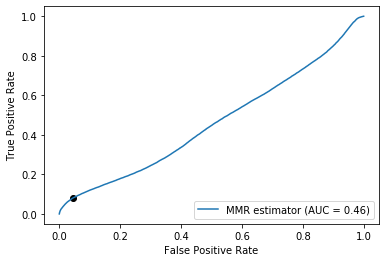

In [133]:
#noexport
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [134]:

precision, recall, thresholds = metrics.precision_recall_curve(t,p)


In [135]:
precision_recall_threshold = np.array(list(zip(precision, recall, thresholds)))
precision_recall_threshold[precision_recall_threshold[:,2] == 0.5]

array([[0.11921059, 0.52849349, 0.5       ]])

In [136]:

precision_recall_threshold[precision_recall_threshold[:,2] == best_thresh]

array([[0.21529348, 0.07960655, 0.73046899]])

In [137]:

fpr, tpr, thresholds = skm.roc_curve(targs.cpu().numpy(),preds.float().softmax(dim=-1).cpu()[...,-1])
auc = skm.auc(fpr, tpr)
print(f'auc = {auc}')


auc = 0.46051476861488394


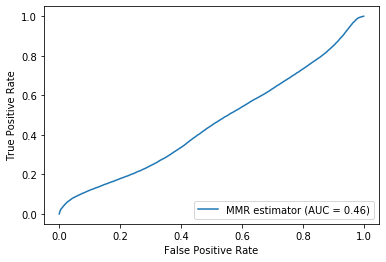

In [138]:
#noexport
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot()  
plt.show() 

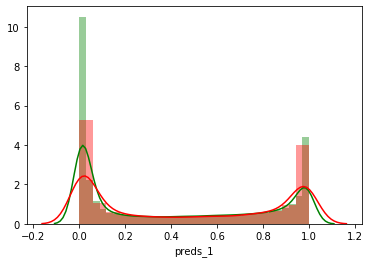

In [139]:
#noexport
import seaborn as sns

df = pd.DataFrame(data=np.c_[preds, targs, losses, decoded],
                    columns=['preds_0', 'preds_1','target', 'loss', 'decoded'])
df_normal = df.loc[df.target == 0, 'preds_0']
df_MMR = df.loc[df.target == 1, 'preds_1']
df_MMR = 1 - df_MMR

sns.distplot(df_normal, hist=True,  color = "g")
sns.distplot(df_MMR, hist=True, color = "r")

In [140]:
#noexport
targs.cpu().numpy(), preds.float().softmax(dim=-1).cpu()

(array([0, 0, 0, ..., 1, 1, 1]),
 TensorImage([[0.3340, 0.6660],
         [0.2768, 0.7232],
         [0.2729, 0.7271],
         ...,
         [0.5953, 0.4047],
         [0.3851, 0.6149],
         [0.3693, 0.6307]]))

In [141]:
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(targs.cpu().numpy(), decoded.cpu())

array([[69094, 98033],
       [11842, 13269]])

In [142]:
best_decoded = preds.float().softmax(dim=-1).cpu()[:,1] > best_thresh


In [143]:
skm.confusion_matrix(targs.cpu().numpy(), best_decoded)

array([[159849,   7278],
       [ 23116,   1995]])

### Agregate prediction by patient

In [144]:
_d_sub.loc[_d_sub.valid == 1, 'preds'] = np.array(preds_val)

_targs = _d_sub.loc[(_d_sub.valid == 1) & ((_d_sub.bias_label == 10) | (_d_sub.bias_label == 20))  ].groupby('patient_ID').label.mean().values
_preds = _d_sub.loc[(_d_sub.valid == 1) & ((_d_sub.bias_label == 10) | (_d_sub.bias_label == 20)) ].groupby('patient_ID').preds.mean().values
#_targs = _d_sub.loc[(_d_sub.valid == 1) ].groupby('patient_ID').label.mean().values
#_preds = _d_sub.loc[(_d_sub.valid == 1) ].groupby('patient_ID').preds.mean().values

_targs[_targs == 2.0] = 0
_targs[_targs == 1.0] = 1
_preds = _preds[_targs >= 0]

_targs = _targs[_targs >= 0]
#print(_targs,_preds)

t = _targs #MSS is labeled as 0, MSI as 1
p = _preds
fpr, tpr, thresholds = skm.roc_curve(_targs,_preds)
fpr, tpr, thresholds = skm.roc_curve(t,p)
#get the best threshold
j = tpr - fpr
ix = np.argmax(j)
best_thresh = thresholds[ix]
auc = skm.auc(fpr, tpr)
print(f'Agregated auc = {auc}, best threshold = {best_thresh}')


AttributeError: 'DataFrame' object has no attribute 'bias_label'

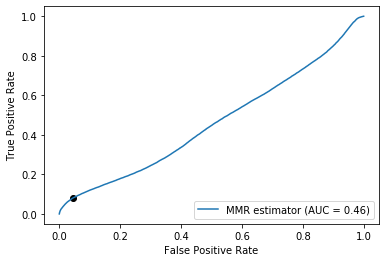

In [145]:
#noexport
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MMR estimator')
display.plot() 
plt.scatter(fpr[ix], tpr[ix], marker = 'o', color = 'black', label = 'Best')
plt.show() 

In [146]:
_best_decoded = _preds >= best_thresh
#confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.
#[[TN,FP],[FN,TP]]
skm.confusion_matrix(_targs
                     , _best_decoded)

NameError: name '_targs' is not defined

# SHAP

In [147]:
#noexport
import shap


In [148]:
#noexport
b=learn.dls[0].one_batch()

In [149]:
#noexport
b[0].shape

torch.Size([512, 3, 224, 224])

In [150]:
#noexport
learn.model.force_msi = True

out = learn.model.eval()(b[0][0:10])
out.shape


torch.Size([10, 2])

In [151]:
#noexport
preds = Tensor(out.cpu().detach().numpy())
preds = preds.float().softmax(dim=-1).cpu()
preds

tensor([[2.8389e-02, 9.7161e-01],
        [3.3615e-01, 6.6385e-01],
        [6.1431e-01, 3.8569e-01],
        [9.7984e-01, 2.0158e-02],
        [9.9961e-01, 3.9440e-04],
        [7.1734e-01, 2.8266e-01],
        [6.0356e-03, 9.9396e-01],
        [8.4494e-01, 1.5506e-01],
        [9.7289e-01, 2.7106e-02],
        [4.2934e-01, 5.7066e-01]])

In [152]:
#noexport
xb=Tensor(b[0].cpu()).cuda()

In [153]:
#noexport
learn.model.force_msi = True
e=shap.DeepExplainer(learn.model,xb[:10])

In [154]:
#noexport
id1,id2 = 40,50
yb= b[1].cpu()
test_labels = np.array(yb[id1:id2])
test_labels

array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1])

In [155]:
#noexport
test_images=xb[id1:id2]
shap_values = e.shap_values(test_images)

In [156]:
#noexport
denorm = lambda t:Normalize.from_stats(*tissue_stats).decodes(TensorImage(t))

In [157]:
#noexport
shap_numpy = [np.swapaxes(np.swapaxes(denorm(s), 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(denorm(test_images).cpu().numpy(), 1, -1), 1, 2)
test_numpy.shape

(10, 224, 224, 3)

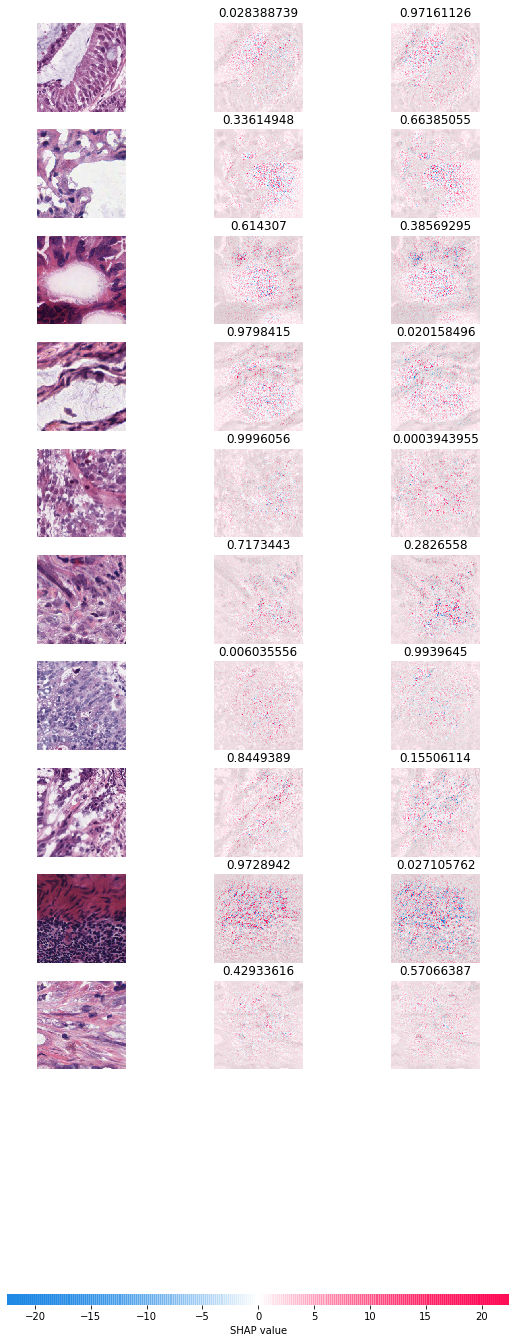

In [158]:
#noexport
shap.image_plot(shap_numpy, test_numpy, labels= preds)